### Seq2Seq

Our first attempts to train a neural networks (lstm with a linear layer for making predictions) was unsuccessful. One of the hypothesis is that the model was too weak. Hence, we will try to use a stronger Seq2Seq model.

In [1]:
import pandas as pd
import torch
pd.set_option('display.float_format', '{:.6f}'.format)

In [2]:
from split_data import split_dataframe
from normalisation import standardize_data
df_h1 = pd.read_csv('ETT-small/ETTh1.csv')
df_h1['date'] = pd.to_datetime(df_h1['date'])
df_h2 = pd.read_csv('ETT-small/ETTh2.csv')
df_h2['date'] = pd.to_datetime(df_h2['date'])
df_m1 = pd.read_csv('ETT-small/ETTm1.csv')
df_m1['date'] = pd.to_datetime(df_m1['date'])
df_m2 = pd.read_csv('ETT-small/ETTm2.csv')
df_m2['date'] = pd.to_datetime(df_m2['date'])
train_h1, val_h1, test_h1 = split_dataframe(df_h1)
train_h1, val_h1, test_h1 = standardize_data(train_h1, val_h1, test_h1)
train_h2, val_h2, test_h2 = split_dataframe(df_h2)
train_h2, val_h2, test_h2 = standardize_data(train_h2, val_h2, test_h2)
train_m1, val_m1, test_m1 = split_dataframe(df_m1)
train_m1, val_m1, test_m1 = standardize_data(train_m1, val_m1, test_m1)
train_m2, val_m2, test_m2 = split_dataframe(df_m2)
train_m2, val_m2, test_m2 = standardize_data(train_m2, val_m2, test_m2)

In [3]:
SEQ_LENGTH = 96       # Input window size, and 96 is very small. Maybe change it to 256, for example
FORECAST_STEPS = 96   # Number of steps to predict
BATCH_SIZE = 256
def create_dataloaders(train, val, test, SEQ_LENGTH=SEQ_LENGTH, FORECAST_STEPS=FORECAST_STEPS):
    train_data = train[features].values
    val_data = val[features].values
    test_data = test[features].values
    train_dataset = TimeSeriesDataset(train_data, SEQ_LENGTH, FORECAST_STEPS)
    val_dataset = TimeSeriesDataset(val_data, SEQ_LENGTH, FORECAST_STEPS)
    test_dataset = TimeSeriesDataset(test_data, SEQ_LENGTH, FORECAST_STEPS)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

cuda:1


##### h1

In [5]:
from lstm_seq2seq import *
INPUT_SIZE = len(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']) # Number of input features
OUTPUT_SIZE = 1        # Predicting only 'OT' feature at each step
features = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
HIDDEN_SIZE = 256       # LSTM hidden dimensions. Default is 64
NUM_LAYERS = 2        # Number of LSTM layers
DROPOUT = 0.5         # Dropout rate
SEQ_LENGTH = 96       # Number of past time steps to use as input
LEARNING_RATE = 0.0001
N_EPOCHS = 50
N_EARLY_STOP = 10
TEACHER_FORCING_START_RATIO = 0.6 # Initial teacher forcing ratio

In [6]:
def full_train_pipeline(train, val, test, model_save_path, plot_filename, FORECAST_STEPS=FORECAST_STEPS, HIDDEN_SIZE=HIDDEN_SIZE):
    train_loader, val_loader, test_loader = create_dataloaders(train, val, test, SEQ_LENGTH, FORECAST_STEPS)
    encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
    decoder = Decoder(OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
    seq2seq_model = Seq2Seq(encoder, decoder, device).to(device)
    trained_model = train_seq2seq(seq2seq_model, train_loader, val_loader, device,
                            LEARNING_RATE, N_EPOCHS, N_EARLY_STOP,
                            save_path=model_save_path, criterion=nn.L1Loss(),
                            teacher_forcing_start_ratio=TEACHER_FORCING_START_RATIO)
    mse_single, mae_single, _, _ = evaluate_single_seq2seq_forecast(
        trained_model,
        val,
        test,
        SEQ_LENGTH,
        FORECAST_STEPS,
        features,
        target_col_index=-1,
        save_plot=True,
        plot_filename=plot_filename,
    )
    return trained_model, mse_single, mae_single

### Identify the best hidden_dimension

Other hyperparameters are set to be constant.

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 6.20s
	Train Loss: 0.7233 | Val Loss: 0.9350
	Validation loss decreased (0.9350). Saving model...
Epoch 2/50 | Time: 5.46s
	Train Loss: 0.2951 | Val Loss: 0.5326
	Validation loss decreased (0.5326). Saving model...
Epoch 3/50 | Time: 5.70s
	Train Loss: 0.2215 | Val Loss: 0.4021
	Validation loss decreased (0.4021). Saving model...
Epoch 4/50 | Time: 5.58s
	Train Loss: 0.2140 | Val Loss: 0.4466
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 5/50 | Time: 5.43s
	Train Loss: 0.2092 | Val Loss: 0.4341
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 6/50 | Time: 5.49s
	Train Loss: 0.2045 | Val Loss: 0.4497
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 7/50 | Time: 5.55s
	Train Loss: 0.2012 | Val Loss: 0.4419
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 8/50 | Time: 5.58s
	Train Loss: 0.1967 | Val Loss: 0.4381
	Validation loss did not improve. Early stopping counter: 5/10
Epoch 9/50 | T

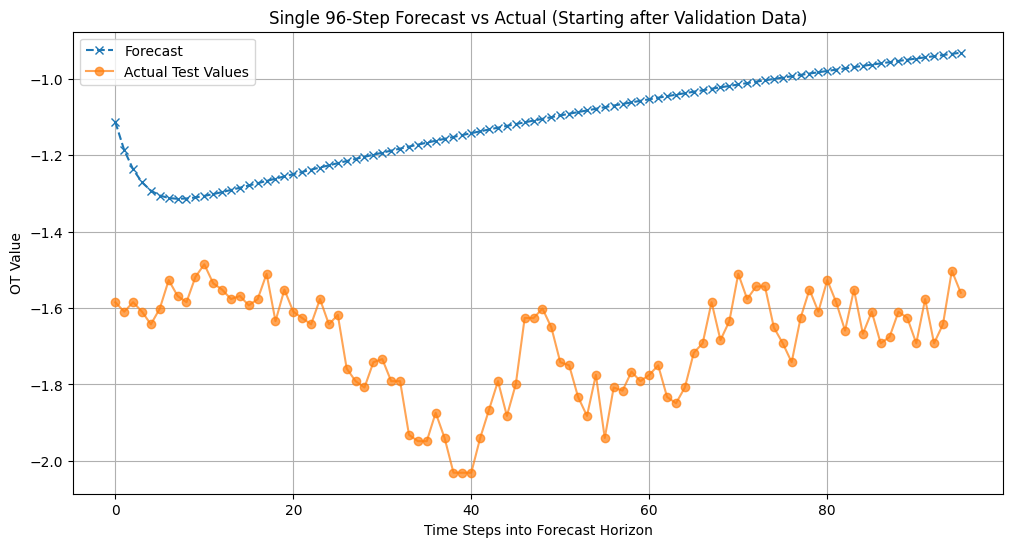

In [7]:
FORECAST_STEPS = 96   # Number of future time steps to predict
HIDDEN_SIZE = 256
seq2seq_h1_96, mse_h1_96, mae_h1_96 = full_train_pipeline(
    train_h1,
    val_h1,
    test_h1,
    model_save_path='seq2seq_weights/exp.pt',
    plot_filename='results_images/exp.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 7.65s
	Train Loss: 0.5648 | Val Loss: 0.4977
	Validation loss decreased (0.4977). Saving model...
Epoch 2/50 | Time: 7.50s
	Train Loss: 0.2229 | Val Loss: 0.4837
	Validation loss decreased (0.4837). Saving model...
Epoch 3/50 | Time: 7.49s
	Train Loss: 0.2061 | Val Loss: 0.3498
	Validation loss decreased (0.3498). Saving model...
Epoch 4/50 | Time: 7.48s
	Train Loss: 0.2005 | Val Loss: 0.3484
	Validation loss decreased (0.3484). Saving model...
Epoch 5/50 | Time: 7.51s
	Train Loss: 0.1946 | Val Loss: 0.4389
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 6/50 | Time: 7.64s
	Train Loss: 0.1902 | Val Loss: 0.3762
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 7/50 | Time: 7.51s
	Train Loss: 0.1852 | Val Loss: 0.4825
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 8/50 | Time: 7.50s
	Train Loss: 0.1791 | Val Loss: 0.5000
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 9/50 | Time: 7.50s

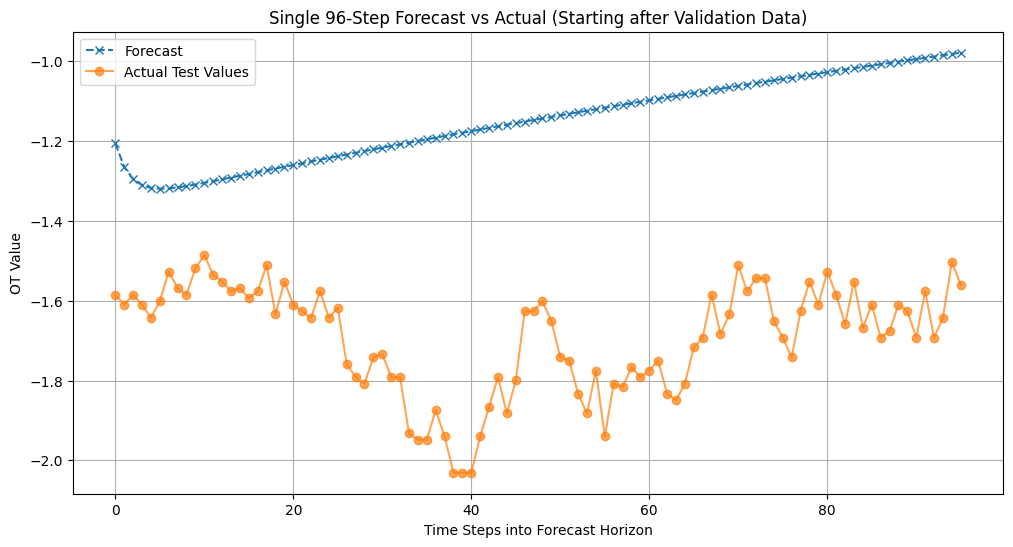

In [8]:
FORECAST_STEPS = 96   # Number of future time steps to predict
HIDDEN_SIZE = 512
seq2seq_h1_96, mse_h1_96, mae_h1_96 = full_train_pipeline(
    train_h1,
    val_h1,
    test_h1,
    model_save_path='seq2seq_weights/exp.pt',
    plot_filename='results_images/exp.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 16.81s
	Train Loss: 0.4514 | Val Loss: 0.7058
	Validation loss decreased (0.7058). Saving model...
Epoch 2/50 | Time: 16.81s
	Train Loss: 0.2079 | Val Loss: 0.4643
	Validation loss decreased (0.4643). Saving model...
Epoch 3/50 | Time: 16.84s
	Train Loss: 0.1949 | Val Loss: 0.3777
	Validation loss decreased (0.3777). Saving model...
Epoch 4/50 | Time: 16.85s
	Train Loss: 0.1886 | Val Loss: 0.3528
	Validation loss decreased (0.3528). Saving model...
Epoch 5/50 | Time: 16.89s
	Train Loss: 0.1825 | Val Loss: 0.4343
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 6/50 | Time: 16.88s
	Train Loss: 0.1729 | Val Loss: 0.5502
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 7/50 | Time: 16.86s
	Train Loss: 0.1651 | Val Loss: 0.5351
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 8/50 | Time: 16.85s
	Train Loss: 0.1571 | Val Loss: 0.6293
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 9/50 | Tim

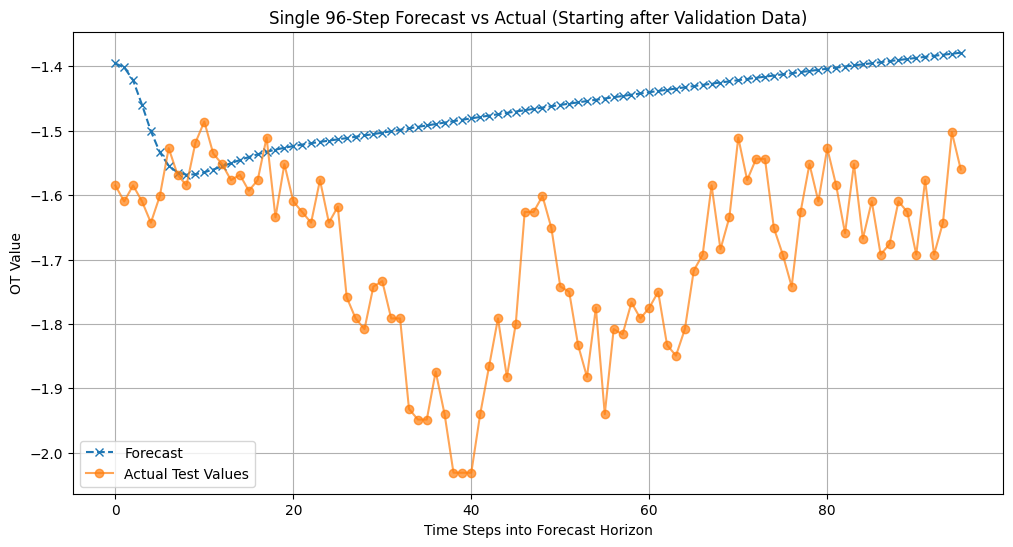

In [9]:
FORECAST_STEPS = 96   # Number of future time steps to predict
HIDDEN_SIZE = 1024
seq2seq_h1_96, mse_h1_96, mae_h1_96 = full_train_pipeline(
    train_h1,
    val_h1,
    test_h1,
    model_save_path='seq2seq_weights/exp.pt',
    plot_filename='results_images/exp.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)

**The best hidden_size was determined to be 1024. Let's stick to this values**

Note that the training process is still very unstable. We discussed the issue in the previous notebook.

##### h1

In [7]:
HIDDEN_SIZE = 1024

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 17.03s
	Train Loss: 0.4270 | Val Loss: 0.5963
	Validation loss decreased (0.5963). Saving model...
Epoch 2/50 | Time: 16.77s
	Train Loss: 0.2035 | Val Loss: 0.3618
	Validation loss decreased (0.3618). Saving model...
Epoch 3/50 | Time: 16.94s
	Train Loss: 0.1931 | Val Loss: 0.3950
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 4/50 | Time: 16.82s
	Train Loss: 0.1842 | Val Loss: 0.4728
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 5/50 | Time: 16.78s
	Train Loss: 0.1763 | Val Loss: 0.4201
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 6/50 | Time: 16.79s
	Train Loss: 0.1679 | Val Loss: 0.4990
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 7/50 | Time: 16.81s
	Train Loss: 0.1576 | Val Loss: 0.4544
	Validation loss did not improve. Early stopping counter: 5/10
Epoch 8/50 | Time: 16.80s
	Train Loss: 0.1537 | Val Loss: 0.3578
	Validation loss decreased (0.3578). Saving model...
Epoch 

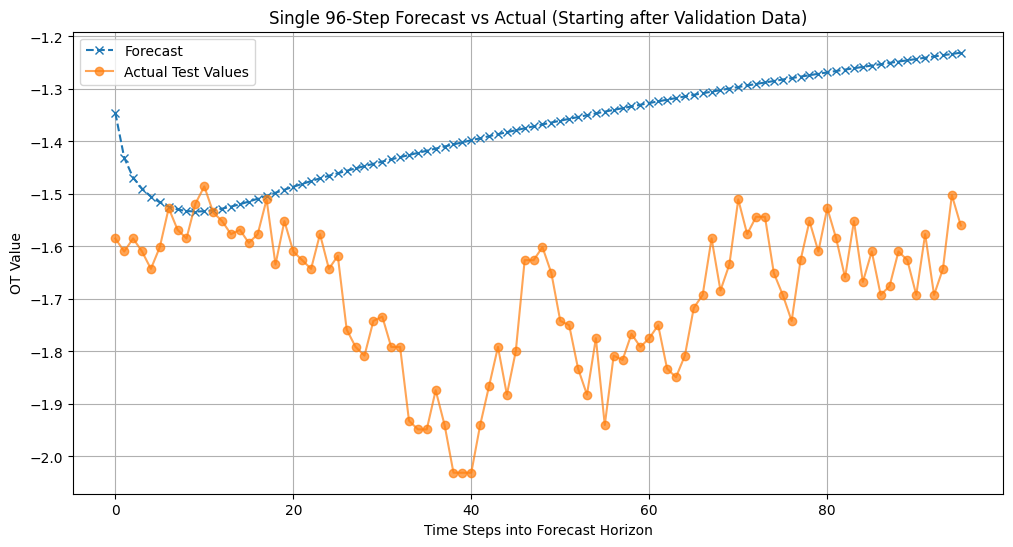

In [8]:
FORECAST_STEPS = 96   # Number of future time steps to predict
seq2seq_h1_96, mse_h1_96, mae_h1_96 = full_train_pipeline(
    train_h1,
    val_h1,
    test_h1,
    model_save_path='seq2seq_weights/best_h1_96.pt',
    plot_filename='results_images/seq2seq_h1_96.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)

In [9]:
metrics = pd.DataFrame(columns=['model', 'prediction_length', 'dataset', 'mse', 'mae'])
metrics

,model,prediction_length,dataset,mse,mae


In [10]:
new_row = pd.DataFrame([['seq2seq', 96, 'h1', mse_h1_96, mae_h1_96]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

/tmp/ipykernel_1381299/3748294636.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, new_row], ignore_index=True)


,model,prediction_length,dataset,mse,mae
0,seq2seq,96,h1,0.128101,0.317324


/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 25.95s
	Train Loss: 0.4358 | Val Loss: 0.7633
	Validation loss decreased (0.7633). Saving model...
Epoch 2/50 | Time: 26.11s
	Train Loss: 0.2079 | Val Loss: 0.5415
	Validation loss decreased (0.5415). Saving model...
Epoch 3/50 | Time: 26.04s
	Train Loss: 0.1981 | Val Loss: 0.3966
	Validation loss decreased (0.3966). Saving model...
Epoch 4/50 | Time: 25.99s
	Train Loss: 0.1894 | Val Loss: 0.5361
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 5/50 | Time: 26.01s
	Train Loss: 0.1831 | Val Loss: 0.5088
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 6/50 | Time: 26.08s
	Train Loss: 0.1752 | Val Loss: 0.5424
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 7/50 | Time: 26.00s
	Train Loss: 0.1660 | Val Loss: 0.5643
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 8/50 | Time: 26.02s
	Train Loss: 0.1575 | Val Loss: 0.5805
	Validation loss did not improve. Early stopping counter: 5/10
Epoch 

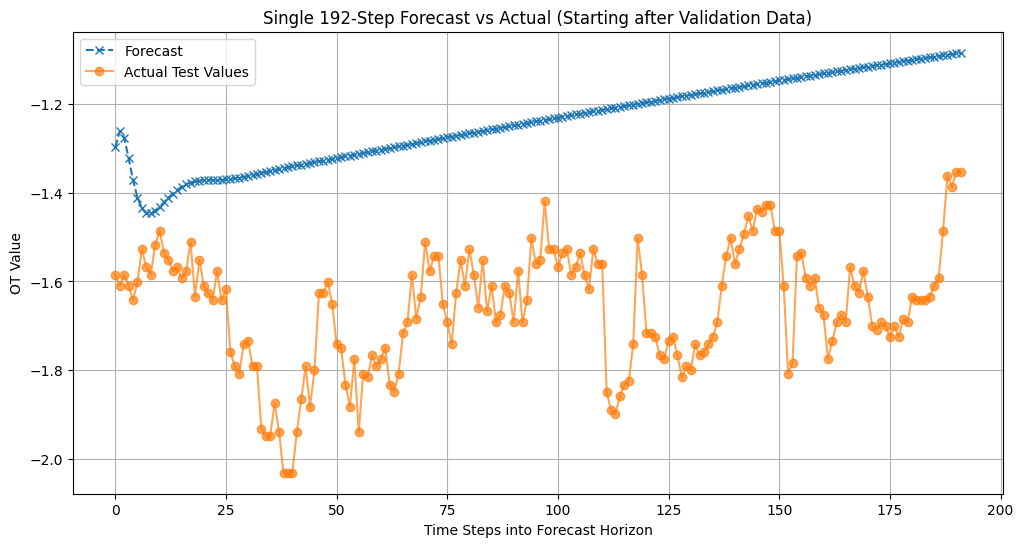

,model,prediction_length,dataset,mse,mae
0,seq2seq,96,h1,0.128101,0.317324
1,seq2seq,192,h1,0.197308,0.419526


In [11]:
FORECAST_STEPS = 192   # Number of future time steps to predict
seq2seq_h1_192, mse_h1_192, mae_h1_192 = full_train_pipeline(
    train_h1,
    val_h1,
    test_h1,
    model_save_path='seq2seq_weights/best_h1_192.pt',
    plot_filename='results_images/seq2seq_h1_192.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)
new_row = pd.DataFrame([['seq2seq', 192, 'h1', mse_h1_192, mae_h1_192]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

**Results are not good, as usually for h1. We discussed the reasons of this issue in the previous notebook. Instead of focusing on it, let's see if the model will be able to capture the patterns in the next time series.**

##### h2

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 16.86s
	Train Loss: 0.5108 | Val Loss: 0.3925
	Validation loss decreased (0.3925). Saving model...
Epoch 2/50 | Time: 16.86s
	Train Loss: 0.2894 | Val Loss: 0.3781
	Validation loss decreased (0.3781). Saving model...
Epoch 3/50 | Time: 16.89s
	Train Loss: 0.2808 | Val Loss: 0.3936
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 4/50 | Time: 16.89s
	Train Loss: 0.2721 | Val Loss: 0.4089
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 5/50 | Time: 16.85s
	Train Loss: 0.2471 | Val Loss: 0.5646
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 6/50 | Time: 16.86s
	Train Loss: 0.1985 | Val Loss: 0.3824
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 7/50 | Time: 16.86s
	Train Loss: 0.1717 | Val Loss: 0.3655
	Validation loss decreased (0.3655). Saving model...
Epoch 8/50 | Time: 16.87s
	Train Loss: 0.1604 | Val Loss: 0.3485
	Validation loss decreased (0.3485). Saving model...
Epoch 9/50 | Tim

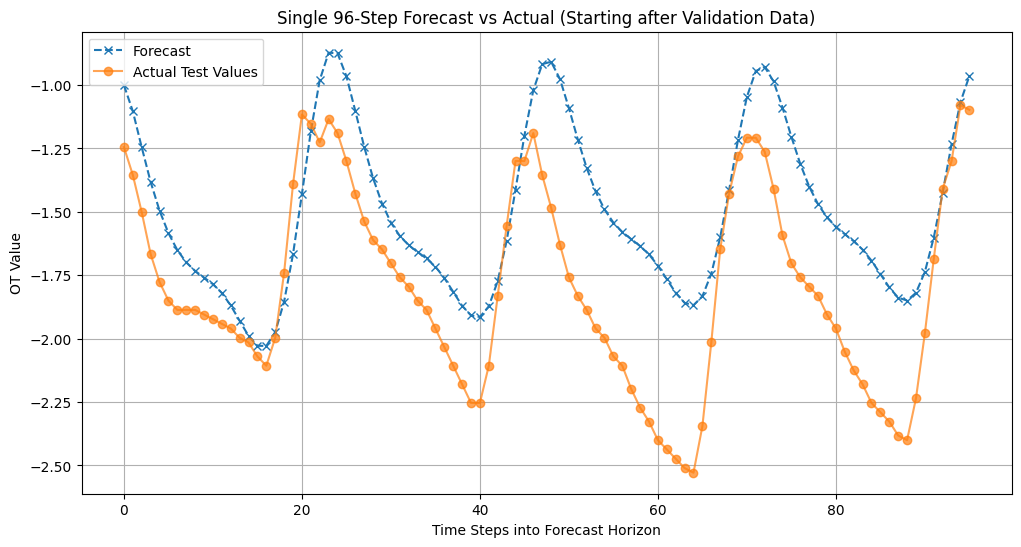

,model,prediction_length,dataset,mse,mae
0,seq2seq,96,h1,0.128101,0.317324
1,seq2seq,192,h1,0.197308,0.419526
2,seq2seq,96,h2,0.139293,0.316190


In [12]:
FORECAST_STEPS = 96   # Number of future time steps to predict
seq2seq_h2_96, mse_h2_96, mae_h2_96 = full_train_pipeline(
    train_h2,
    val_h2,
    test_h2,
    model_save_path='seq2seq_weights/best_h2_96.pt',
    plot_filename='results_images/seq2seq_h2_96.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)
new_row = pd.DataFrame([['seq2seq', 96, 'h2', mse_h2_96, mae_h2_96]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 26.00s
	Train Loss: 0.5132 | Val Loss: 0.4499
	Validation loss decreased (0.4499). Saving model...
Epoch 2/50 | Time: 26.02s
	Train Loss: 0.2917 | Val Loss: 0.4210
	Validation loss decreased (0.4210). Saving model...
Epoch 3/50 | Time: 26.10s
	Train Loss: 0.2828 | Val Loss: 0.4684
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 4/50 | Time: 26.02s
	Train Loss: 0.2749 | Val Loss: 0.5062
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 5/50 | Time: 26.02s
	Train Loss: 0.2576 | Val Loss: 0.4750
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 6/50 | Time: 26.10s
	Train Loss: 0.2084 | Val Loss: 0.4544
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 7/50 | Time: 26.01s
	Train Loss: 0.1699 | Val Loss: 0.3887
	Validation loss decreased (0.3887). Saving model...
Epoch 8/50 | Time: 26.04s
	Train Loss: 0.1558 | Val Loss: 0.3802
	Validation loss decreased (0.3802). Saving model...
Epoch 9/50 | Tim

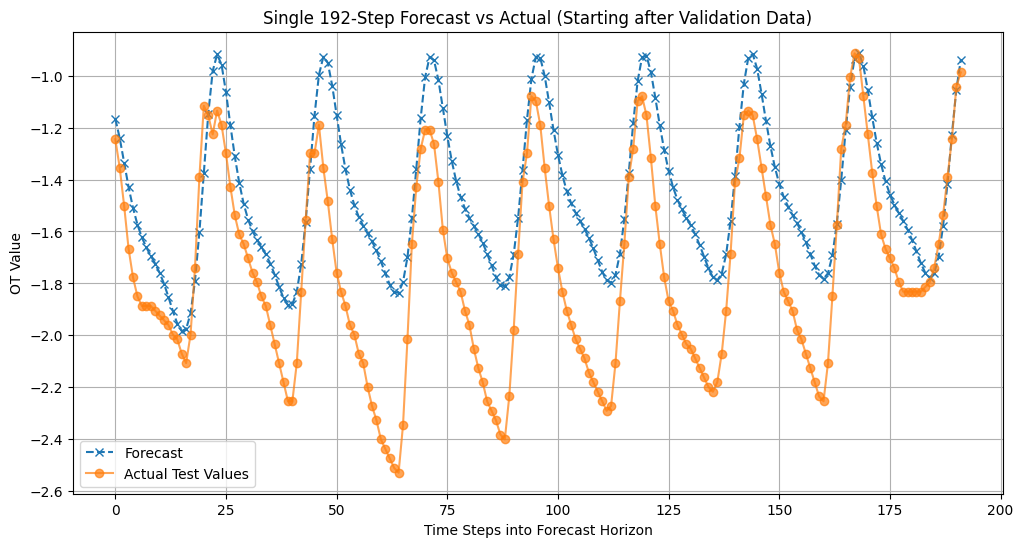

,model,prediction_length,dataset,mse,mae
0,seq2seq,96,h1,0.128101,0.317324
1,seq2seq,192,h1,0.197308,0.419526
2,seq2seq,96,h2,0.139293,0.316190
3,seq2seq,192,h2,0.123683,0.300938


In [13]:
FORECAST_STEPS = 192  # Number of future time steps to predict
seq2seq_h2_192, mse_h2_192, mae_h2_192 = full_train_pipeline(
    train_h2,
    val_h2,
    test_h2,
    model_save_path='seq2seq_weights/best_h2_192.pt',
    plot_filename='results_images/seq2seq_h2_192.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)
new_row = pd.DataFrame([['seq2seq', 192, 'h2', mse_h2_192, mae_h2_192]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

**The model is still imperfect and slightly biased, but it is significantly better than the previous lstm model (with a linear layer). Hence, for time series forecasting and in particular for this dataset, it is worth experimenting with different architectures and do hyper-parameter tuning**

##### m1

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 68.57s
	Train Loss: 0.1862 | Val Loss: 0.3346
	Validation loss decreased (0.3346). Saving model...
Epoch 2/50 | Time: 68.50s
	Train Loss: 0.0937 | Val Loss: 0.3104
	Validation loss decreased (0.3104). Saving model...
Epoch 3/50 | Time: 68.30s
	Train Loss: 0.0860 | Val Loss: 0.1842
	Validation loss decreased (0.1842). Saving model...
Epoch 4/50 | Time: 68.34s
	Train Loss: 0.0814 | Val Loss: 0.1896
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 5/50 | Time: 68.29s
	Train Loss: 0.0780 | Val Loss: 0.2244
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 6/50 | Time: 68.30s
	Train Loss: 0.0747 | Val Loss: 0.5421
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 7/50 | Time: 68.59s
	Train Loss: 0.0724 | Val Loss: 0.3189
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 8/50 | Time: 68.51s
	Train Loss: 0.0705 | Val Loss: 0.2771
	Validation loss did not improve. Early stopping counter: 5/10
Epoch 

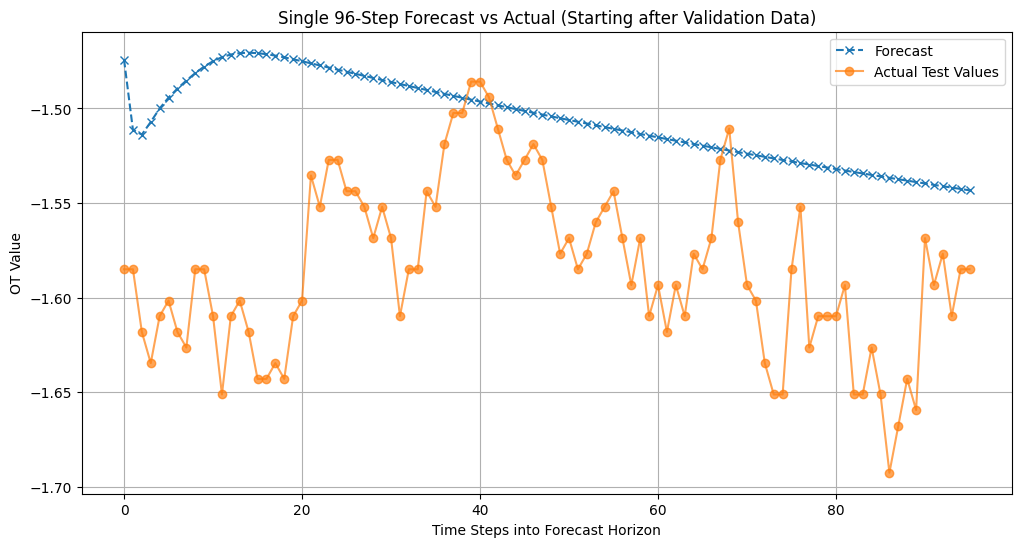

,model,prediction_length,dataset,mse,mae
0,seq2seq,96,h1,0.128101,0.317324
1,seq2seq,192,h1,0.197308,0.419526
2,seq2seq,96,h2,0.139293,0.316190
3,seq2seq,192,h2,0.123683,0.300938
4,seq2seq,96,m1,0.008156,0.079113


In [14]:
FORECAST_STEPS = 96   # Number of future time steps to predict
seq2seq_m1_96, mse_m1_96, mae_m1_96 = full_train_pipeline(
    train_m1,
    val_m1,
    test_m1,
    model_save_path='seq2seq_weights/best_m1_96.pt',
    plot_filename='results_images/seq2seq_m1_96.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)
new_row = pd.DataFrame([['seq2seq', 96, 'm1', mse_m1_96, mae_m1_96]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 107.36s
	Train Loss: 0.1915 | Val Loss: 0.3395
	Validation loss decreased (0.3395). Saving model...
Epoch 2/50 | Time: 106.67s
	Train Loss: 0.0953 | Val Loss: 0.2203
	Validation loss decreased (0.2203). Saving model...
Epoch 3/50 | Time: 107.02s
	Train Loss: 0.0863 | Val Loss: 0.3675
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 4/50 | Time: 107.03s
	Train Loss: 0.0814 | Val Loss: 0.3433
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 5/50 | Time: 107.03s
	Train Loss: 0.0773 | Val Loss: 0.2681
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 6/50 | Time: 106.95s
	Train Loss: 0.0745 | Val Loss: 0.3628
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 7/50 | Time: 107.05s
	Train Loss: 0.0721 | Val Loss: 0.3674
	Validation loss did not improve. Early stopping counter: 5/10
Epoch 8/50 | Time: 106.78s
	Train Loss: 0.0707 | Val Loss: 0.4846
	Validation loss did not improve. Early stopping co

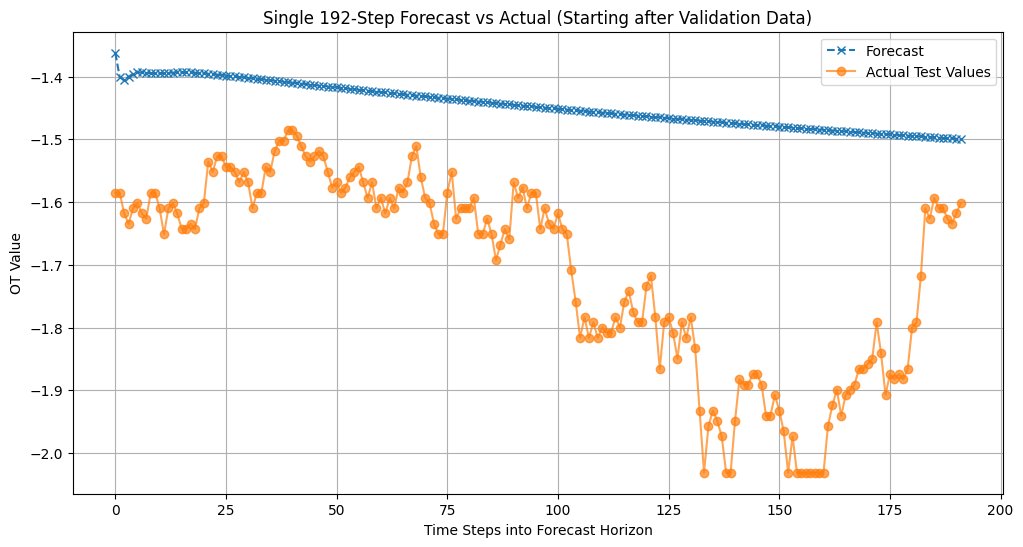

,model,prediction_length,dataset,mse,mae
0,seq2seq,96,h1,0.128101,0.317324
1,seq2seq,192,h1,0.197308,0.419526
2,seq2seq,96,h2,0.139293,0.316190
3,seq2seq,192,h2,0.123683,0.300938
4,seq2seq,96,m1,0.008156,0.079113
5,seq2seq,192,m1,0.086514,0.262605


In [15]:
FORECAST_STEPS = 192  # Number of future time steps to predict
seq2seq_m1_192, mse_m1_192, mae_m1_192 = full_train_pipeline(
    train_m1,
    val_m1,
    test_m1,
    model_save_path='seq2seq_weights/best_m1_192.pt',
    plot_filename='results_images/seq2seq_m1_192.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)
new_row = pd.DataFrame([['seq2seq', 192, 'm1', mse_m1_192, mae_m1_192]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

##### m2

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 68.53s
	Train Loss: 0.1983 | Val Loss: 0.4223
	Validation loss decreased (0.4223). Saving model...
Epoch 2/50 | Time: 68.33s
	Train Loss: 0.0736 | Val Loss: 0.3831
	Validation loss decreased (0.3831). Saving model...
Epoch 3/50 | Time: 68.36s
	Train Loss: 0.0664 | Val Loss: 0.7468
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 4/50 | Time: 68.45s
	Train Loss: 0.0624 | Val Loss: 0.4204
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 5/50 | Time: 68.35s
	Train Loss: 0.0591 | Val Loss: 0.4142
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 6/50 | Time: 68.51s
	Train Loss: 0.0559 | Val Loss: 0.4252
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 7/50 | Time: 68.57s
	Train Loss: 0.0537 | Val Loss: 0.4035
	Validation loss did not improve. Early stopping counter: 5/10
Epoch 8/50 | Time: 68.35s
	Train Loss: 0.0526 | Val Loss: 0.4102
	Validation loss did not improve. Early stopping counter: 6

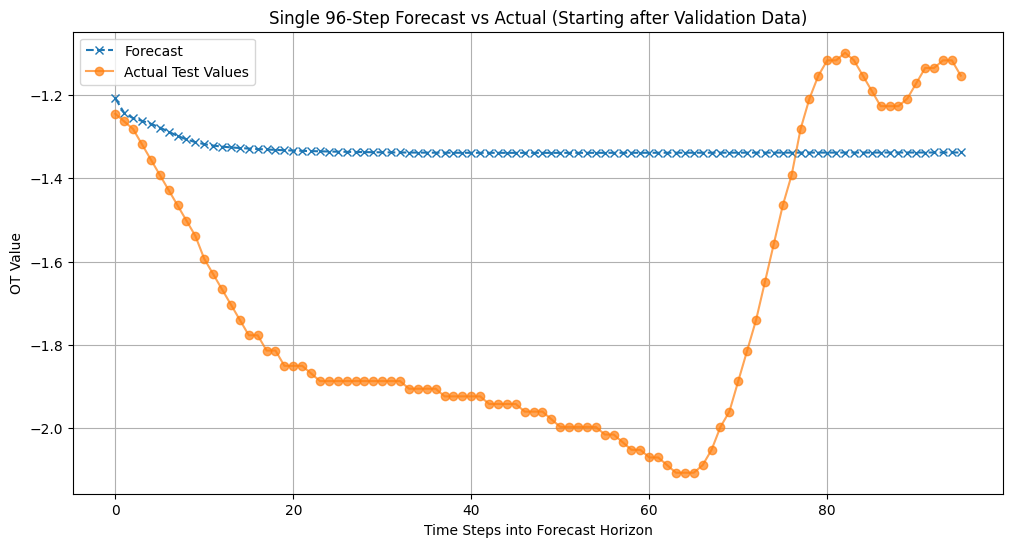

,model,prediction_length,dataset,mse,mae
0,seq2seq,96,h1,0.128101,0.317324
1,seq2seq,192,h1,0.197308,0.419526
2,seq2seq,96,h2,0.139293,0.316190
3,seq2seq,192,h2,0.123683,0.300938
4,seq2seq,96,m1,0.008156,0.079113
5,seq2seq,192,m1,0.086514,0.262605
6,seq2seq,96,m2,0.241026,0.435481


In [16]:
FORECAST_STEPS = 96   # Number of future time steps to predict
seq2seq_m2_96, mse_m2_96, mae_m2_96 = full_train_pipeline(
    train_m2,
    val_m2,
    test_m2,
    model_save_path='seq2seq_weights/best_m2_96.pt',
    plot_filename='results_images/seq2seq_m2_96.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)
new_row = pd.DataFrame([['seq2seq', 96, 'm2', mse_m2_96, mae_m2_96]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 107.01s
	Train Loss: 0.2124 | Val Loss: 0.4847
	Validation loss decreased (0.4847). Saving model...
Epoch 2/50 | Time: 106.63s
	Train Loss: 0.0773 | Val Loss: 0.4440
	Validation loss decreased (0.4440). Saving model...
Epoch 3/50 | Time: 106.81s
	Train Loss: 0.0681 | Val Loss: 0.5656
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 4/50 | Time: 106.60s
	Train Loss: 0.0632 | Val Loss: 0.5612
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 5/50 | Time: 106.59s
	Train Loss: 0.0599 | Val Loss: 0.7365
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 6/50 | Time: 107.01s
	Train Loss: 0.0572 | Val Loss: 0.5144
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 7/50 | Time: 107.09s
	Train Loss: 0.0544 | Val Loss: 0.4869
	Validation loss did not improve. Early stopping counter: 5/10
Epoch 8/50 | Time: 106.67s
	Train Loss: 0.0533 | Val Loss: 0.5709
	Validation loss did not improve. Early stopping co

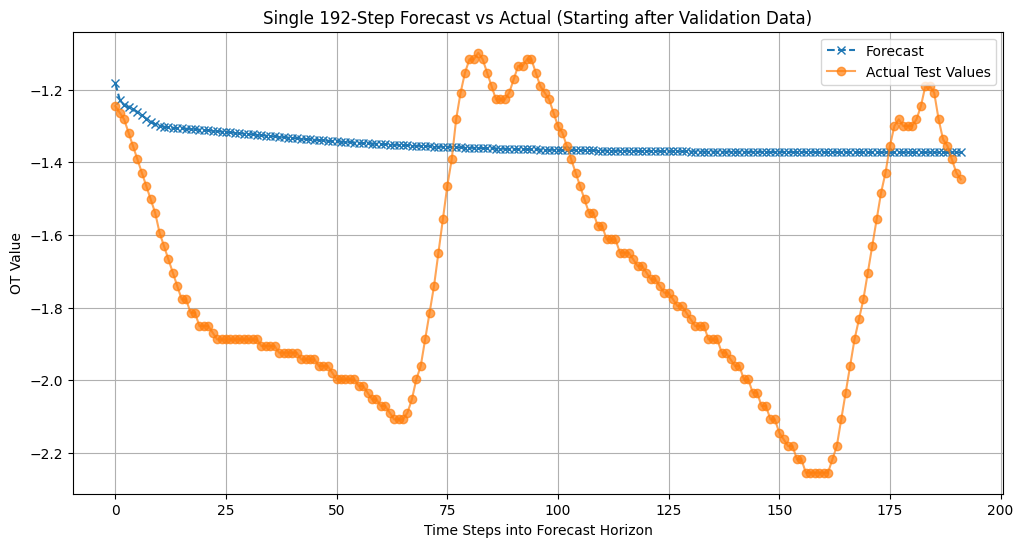

,model,prediction_length,dataset,mse,mae
0,seq2seq,96,h1,0.128101,0.317324
1,seq2seq,192,h1,0.197308,0.419526
2,seq2seq,96,h2,0.139293,0.316190
3,seq2seq,192,h2,0.123683,0.300938
4,seq2seq,96,m1,0.008156,0.079113
5,seq2seq,192,m1,0.086514,0.262605
6,seq2seq,96,m2,0.241026,0.435481
7,seq2seq,192,m2,0.236756,0.417376


In [17]:
FORECAST_STEPS = 192   # Number of future time steps to predict
seq2seq_m2_192, mse_m2_192, mae_m2_192 = full_train_pipeline(
    train_m2,
    val_m2,
    test_m2,
    model_save_path='seq2seq_weights/best_m2_192.pt',
    plot_filename='results_images/seq2seq_m2_192.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)
new_row = pd.DataFrame([['seq2seq', 192, 'm2', mse_m2_192, mae_m2_192]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

In [18]:
metrics.to_csv('seq2seq_metrics.csv', index=False)

**We see that for m1 and m2, the results on the validation sample could not improve after the first two epochs. Hence, the model was not able to train properly, and the predictions are nearly constant. Let's see if the decrease in the hidden size will result in the improvement for the m2 validation sample**

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 30.37s
	Train Loss: 0.2766 | Val Loss: 0.3363
	Validation loss decreased (0.3363). Saving model...
Epoch 2/50 | Time: 30.23s
	Train Loss: 0.0990 | Val Loss: 0.6000
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 3/50 | Time: 30.12s
	Train Loss: 0.0833 | Val Loss: 0.3847
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 4/50 | Time: 30.07s
	Train Loss: 0.0777 | Val Loss: 0.3967
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 5/50 | Time: 30.07s
	Train Loss: 0.0737 | Val Loss: 0.3920
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 6/50 | Time: 30.11s
	Train Loss: 0.0708 | Val Loss: 0.3842
	Validation loss did not improve. Early stopping counter: 5/10
Epoch 7/50 | Time: 30.13s
	Train Loss: 0.0697 | Val Loss: 0.3857
	Validation loss did not improve. Early stopping counter: 6/10
Epoch 8/50 | Time: 30.20s
	Train Loss: 0.0678 | Val Loss: 0.3828
	Validation loss did not improve. Early stopping 

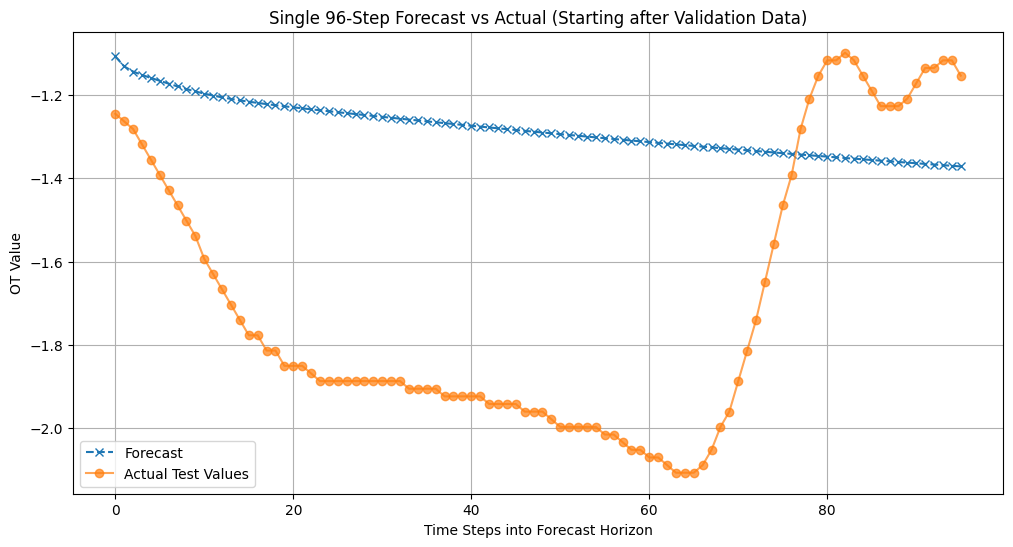

,model,prediction_length,dataset,mse,mae
0,seq2seq,96,h1,0.128101,0.317324
1,seq2seq,192,h1,0.197308,0.419526
2,seq2seq,96,h2,0.139293,0.316190
3,seq2seq,192,h2,0.123683,0.300938
4,seq2seq,96,m1,0.008156,0.079113
5,seq2seq,192,m1,0.086514,0.262605
6,seq2seq,96,m2,0.241026,0.435481
7,seq2seq,192,m2,0.236756,0.417376
8,seq2seq_less_hidden,96,m2,0.294263,0.492442


In [19]:
FORECAST_STEPS = 96   # Number of future time steps to predict
HIDDEN_SIZE = 512
seq2seq_m2_96, mse_m2_96, mae_m2_96 = full_train_pipeline(
    train_m2,
    val_m2,
    test_m2,
    model_save_path='seq2seq_weights/best_m2_96_v2.pt',
    plot_filename='results_images/seq2seq_m2_96_v2.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)
new_row = pd.DataFrame([['seq2seq_less_hidden', 96, 'm2', mse_m2_96, mae_m2_96]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

/home/alex/anaconda3/envs/test/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Time: 48.96s
	Train Loss: 0.2791 | Val Loss: 0.4074
	Validation loss decreased (0.4074). Saving model...
Epoch 2/50 | Time: 50.56s
	Train Loss: 0.0955 | Val Loss: 0.4705
	Validation loss did not improve. Early stopping counter: 1/10
Epoch 3/50 | Time: 51.16s
	Train Loss: 0.0819 | Val Loss: 0.4948
	Validation loss did not improve. Early stopping counter: 2/10
Epoch 4/50 | Time: 50.24s
	Train Loss: 0.0761 | Val Loss: 0.4421
	Validation loss did not improve. Early stopping counter: 3/10
Epoch 5/50 | Time: 50.47s
	Train Loss: 0.0717 | Val Loss: 0.4824
	Validation loss did not improve. Early stopping counter: 4/10
Epoch 6/50 | Time: 50.20s
	Train Loss: 0.0693 | Val Loss: 0.4932
	Validation loss did not improve. Early stopping counter: 5/10
Epoch 7/50 | Time: 48.95s
	Train Loss: 0.0676 | Val Loss: 0.4422
	Validation loss did not improve. Early stopping counter: 6/10
Epoch 8/50 | Time: 49.35s
	Train Loss: 0.0661 | Val Loss: 0.4552
	Validation loss did not improve. Early stopping 

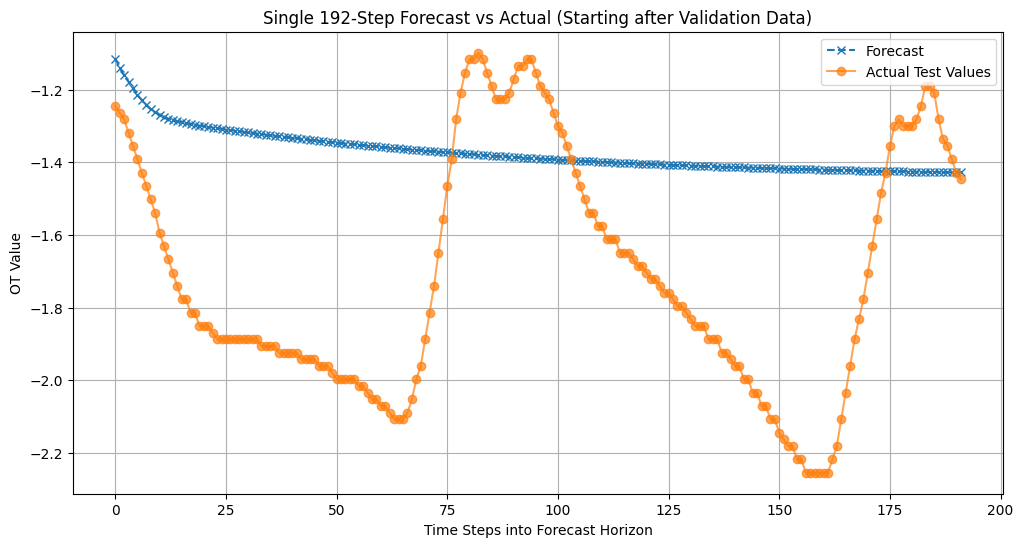

,model,prediction_length,dataset,mse,mae
0,seq2seq,96,h1,0.128101,0.317324
1,seq2seq,192,h1,0.197308,0.419526
2,seq2seq,96,h2,0.139293,0.316190
3,seq2seq,192,h2,0.123683,0.300938
4,seq2seq,96,m1,0.008156,0.079113
5,seq2seq,192,m1,0.086514,0.262605
6,seq2seq,96,m2,0.241026,0.435481
7,seq2seq,192,m2,0.236756,0.417376
8,seq2seq_less_hidden,96,m2,0.294263,0.492442
9,seq2seq_less_hidden,192,m2,0.224063,0.411332


In [20]:
FORECAST_STEPS = 192   # Number of future time steps to predict
HIDDEN_SIZE = 512
seq2seq_m2_192, mse_m2_192, mae_m2_192 = full_train_pipeline(
    train_m2,
    val_m2,
    test_m2,
    model_save_path='seq2seq_weights/best_m2_192_v2.pt',
    plot_filename='results_images/seq2seq_m2_192_v2.png',
    FORECAST_STEPS=FORECAST_STEPS,
    HIDDEN_SIZE=HIDDEN_SIZE
)
new_row = pd.DataFrame([['seq2seq_less_hidden', 192, 'm2', mse_m2_192, mae_m2_192]],
                        columns=metrics.columns)
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

In [21]:
metrics.to_csv('seq2seq_metrics_v2.csv', index=False)

**As we see, even if we decrease the hidden_size twice, the results do not change. It suggest that it is complicated to optimize the neural networks for time series forecasting in general, and it requires a lot of experiments**